In [1]:
from scipy.io import loadmat
annots = loadmat("results/Gore_Range_Albers_2000m/Gore_Range_Albers_2000m_kernel_x4.mat")

In [2]:
k = annots["Kernel"]
k.shape

(45, 45)

In [ ]:
!pip install matplotlib

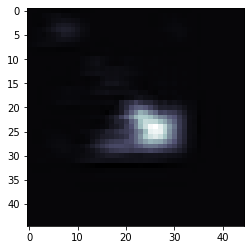

In [3]:
import matplotlib.pyplot as plt
plt.imshow(k, cmap="bone")

In [11]:
type(k)

numpy.ndarray

In [4]:
import rasterio as rio
import numpy as np

dem = rio.open("../../Dataset/Gore_Range_Albers_2000m.asc").read(1).astype('float64')

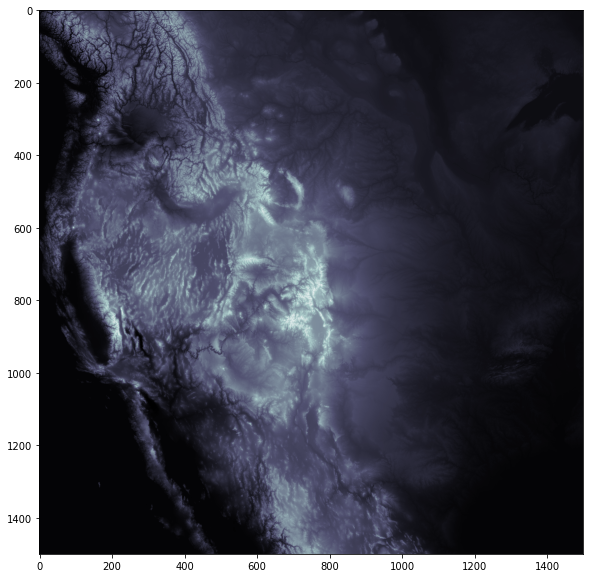

In [5]:
plt.figure(figsize=(20,10))
plt.imshow(dem, cmap="bone")

In [21]:
k.shape

(23, 23)

In [133]:
from scipy.ndimage import correlate

def numeric_kernel(im, kernel, scale_factor, output_shape, kernel_shift_flag):
    # See kernel_shift function to understand what this is
    if kernel_shift_flag:
        kernel = kernel_shift(kernel, scale_factor)

    # First run a correlation (convolution with flipped kernel)
    out_im = np.zeros_like(im)
    out_im = correlate(im, kernel)
    # print(out_im.shape)
    #print(np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None].shape)
    # Then subsample and return
    return out_im[np.round(np.linspace(0, im.shape[0] - 1 / scale_factor[0], output_shape[0])).astype(int)[:, None],
           np.round(np.linspace(0, im.shape[1] - 1 / scale_factor[1], output_shape[1])).astype(int)]

In [58]:
def psnr(a, b):
    L = 10500.0
    rmse = np.sqrt(np.square(a - b).sum())
    print(rmse)
    return 20.0 * np.log10((L-1)/(rmse))

In [53]:
def normalize(im):
    MIN_H = -500.0
    MAX_H = 10000.0
    return (im - MIN_H)/(MAX_H-MIN_H)

In [62]:
%%time
dem = rio.open("../../Dataset/Gore_Range_Albers_2000m.asc").read(1).astype('float64')
k = loadmat("results/Gore_Range_Albers_2000m/Gore_Range_Albers_2000m_kernel_x4.mat")["Kernel"]
down_scaled_x2 = numeric_kernel(dem, k, [0.25,0.25], (375, 375), False)  
#down_scaled_x4 = numeric_kernel(dem, k, [0.25,0.25], (375, 375), False)  

(375, 1)
CPU times: user 6.4 s, sys: 15.9 ms, total: 6.41 s
Wall time: 6.49 s


In [49]:
psnr(out, out)

3589.253229776202


/tmp/ipykernel_12012/1220382284.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  return 20.0 * np.log10((L-1)/(rmse))


inf

In [59]:
psnr(out, down_scaled_x2)

17799.929087142347


-4.585406728247738

In [32]:
(out - down_scaled_x2).sum()

-3413025.4179269923

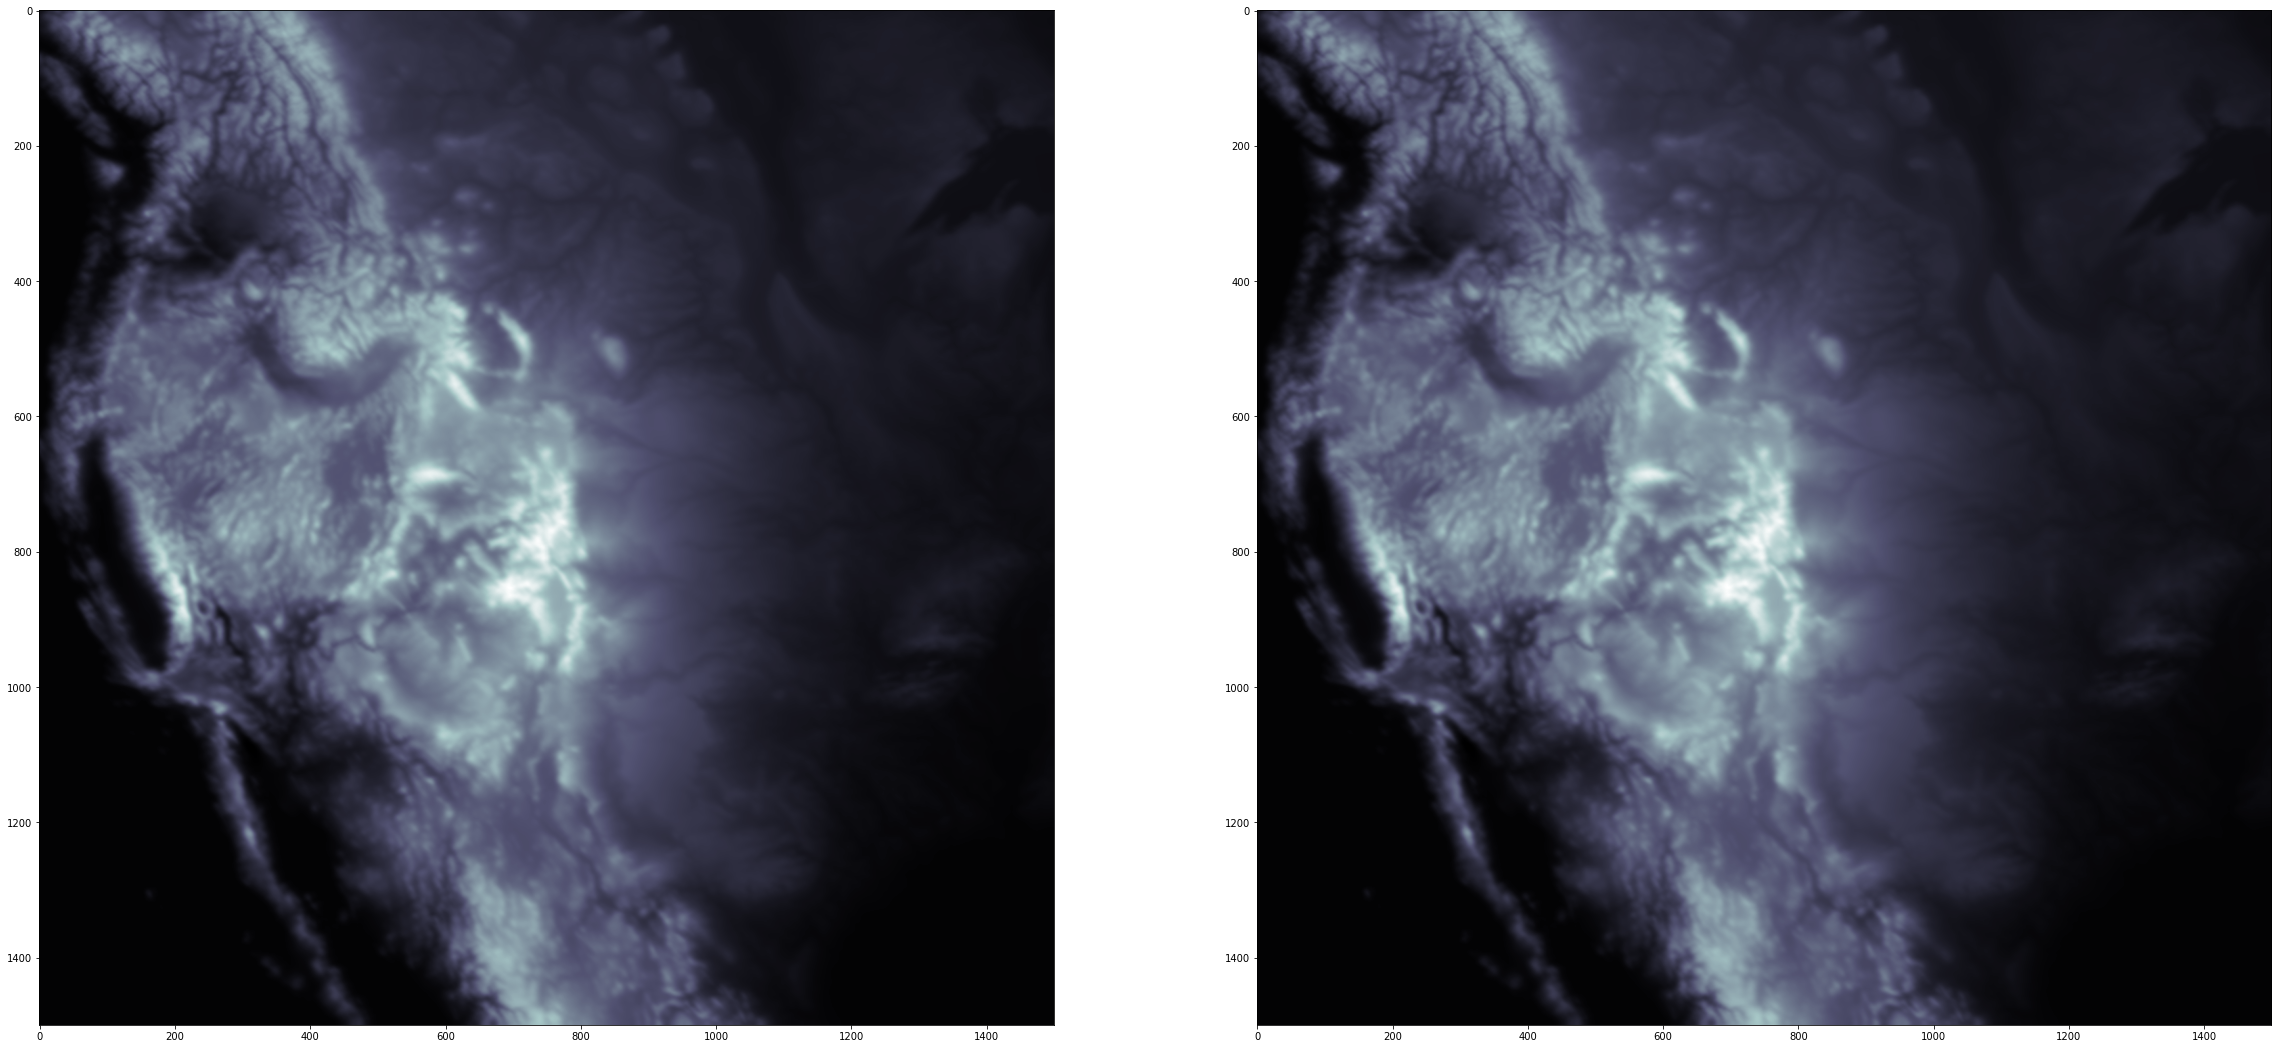

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(40,20))
# plt.figure()
ax[0].imshow(down_scaled_x2, cmap="bone")
ax[1].imshow(out, cmap="bone")

In [ ]:
!pip install torchvision

### Dataset Definition

In [112]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

In [150]:
import os

class DemDataset(Dataset):
    """DEM dataset."""

    def __init__(self, root_dir, kernel_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the DEMs.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.demList = os.listdir(os.path.abspath(root_dir))
        self.kernel_dir = kernel_dir
        #print(self.demList)

    def __len__(self):
        return len(self.demList)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.demList[idx])
        
        k = self.get_Kernel()
        
        # image = io.imread(img_name)
        im = rio.open(img_name).read(1).astype('float')
        HR = RandomCrop(im, 256)
        LR = numeric_kernel(HR, k, [0.25,0.25], (64, 64), False) 
        #print(type(LR))
        if self.transform:
            HR = self.transform(HR)
            LR = self.transform(LR)
            
        sample = {'HR': HR, 'LR': LR}

        return sample
    
    def get_Kernel(self): 
        kernels = os.listdir(self.kernel_dir)
        i = np.random.randint(0, len(kernels))
        k_path = os.path.join(self.kernel_dir, kernels[i])
        k = loadmat(k_path)["Kernel"]

        return k
    
    def RandomCrop(self,image, output_size):
        h, w = image.shape[:2]
        new_h, new_w = (output_size, output_size)

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        return image

In [151]:
data = DemDataset("../../Dataset/", "results/Gore_Range_Albers_250m", transform = transforms.Compose([transforms.ToTensor()]))
dl = DataLoader(dataset=data, batch_size=16, shuffle=True)

In [152]:
data[0]

{'HR': tensor([[[102.7000, 112.4000, 110.6000,  ..., 114.9000, 136.7000,  43.3000],
          [108.8000, 124.6000, 111.8000,  ...,  88.8000, 108.8000,  36.6000],
          [119.1000, 127.0000, 110.0000,  ...,  68.2000,  91.2000,  39.7000],
          ...,
          [  0.2000,   0.2000,   0.2000,  ...,   0.2000,   0.2000,   0.2000],
          [  0.2000,   0.2000,   0.2000,  ...,   0.2000,   0.2000,   0.2000],
          [  0.2000,   0.2000,   0.2000,  ...,   0.2000,   0.2000,   0.2000]]],
        dtype=torch.float64),
 'LR': tensor([[[111.2442, 112.6885, 120.5019,  ...,  88.1183,  83.6161,  85.2746],
          [111.9599, 113.4698, 120.6320,  ..., 100.5043, 102.4546, 108.0505],
          [113.4597, 113.4995, 116.8769,  ..., 106.8262, 111.4634, 117.9517],
          ...,
          [  0.2000,   0.2000,   0.2000,  ...,   0.2006,   0.1993,   0.2008],
          [  0.2000,   0.2000,   0.2000,  ...,   0.2000,   0.2000,   0.2000],
          [  0.2000,   0.2000,   0.2000,  ...,   0.2000,   0.2000,  

In [153]:
for i_batch, sample_batched in enumerate(dl):
    print(i_batch, sample_batched['LR'].size(), sample_batched['HR'].size())

0 torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 256, 256])
1 torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 256, 256])
2 torch.Size([3, 1, 64, 64]) torch.Size([3, 1, 256, 256])
